# DeepOF unsupervised pipeline: exploring the behavioral space

In [7]:
import os
os.chdir("../../..")
import deepof.data

In [8]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pickle
import numpy as np
with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
    vqvae_solution = pickle.load(handle)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deepof.post_hoc import get_transitions
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook as tqdm


def merge_and_smooth_clusters(
    n_clusters, centroids, embedding, concat_embedding, cluster_assignments
):
    """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

    Args:
        n_clusters (int): number of clusters to report.
        centroids (np.ndarray): precomputed means per cluster.
        embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
        concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
        cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

    Returns:
        new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
    """

    # Merge clusters ussing a hierarchical agglomerative approach
    new_hard_assignments = AgglomerativeClustering(
        n_clusters=n_clusters, compute_distances=True
    ).fit_predict(centroids)
    cluster_predictor = LinearDiscriminantAnalysis().fit(
        centroids, new_hard_assignments
    )
    centroids = cluster_predictor.means_
    new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

    # Rebuild the soft assignments dictionary per experimental animal
    new_soft_assignments = np.split(
        new_soft_assignments,
        np.cumsum([i.shape[0] for i in embedding.values()]),
    )
    new_soft_assignments = {
        key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
    }

    # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
    for key, val in tqdm(new_soft_assignments.items()):

        hmm = GaussianHMM(
            startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
            transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
            means_prior=centroids,
            n_components=n_clusters,
            covariance_type="diag",
            n_iter=100,
            tol=0.0001,
        )
        
        hmm.fit(embedding[key].numpy())
        new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

    return new_soft_assignments


def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
    """Merges clusters using a hierarchical approach.

    Args:
        embedding (list): list of embeddings per animal in the dataset.
        cluster_assignments (list): list of cluster assignments per animal in the dataset.
        n_clusters (int): number of clusters to report.

    Returns:
        new_soft_assignments (list): list of new (merged) cluster assignments.

    """
    # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
    concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
    hard_assignments = np.concatenate(
        [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
    )

    assert concat_embedding.shape[0] == hard_assignments.shape[0]

    # Get cluster centroids from the concatenated embeddings
    centroids = []
    for cluster in range(np.max(hard_assignments)):
        centroid = concat_embedding[hard_assignments == cluster]
        if len(centroid) == 0:
            continue
        centroid = np.mean(centroid, axis=0)
        centroids.append(centroid)

    centroids = np.stack(centroids)

    # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
    if isinstance(n_clusters, int):
        new_soft_assignments = merge_and_smooth_clusters(
            n_clusters, centroids, embedding, concat_embedding, cluster_assignments
        )

    else:
        raise NotImplementedError

    return new_soft_assignments

In [ ]:
# from hmmlearn.hmm import GaussianHMM

# new_ass = cluster_postprocessing(
#     vqvae_solution[0], 
#     vqvae_solution[1],
#     n_clusters=12
# )
# hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [ ]:
# import umap

# # Cluster on the original embedding space
# new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

# sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

# plt.show()

In [ ]:
# # How prevalent are these clusters?
# from collections import Counter
# print(Counter(hcc))

# new_ass = hcc

In [ ]:
# # How often does the model change clusters?
# from collections import defaultdict

# lengths = defaultdict(list)
# cur = 0
# for i in range(1, len(new_ass)):
#     if new_ass[i-1] == new_ass[i]:
#         cur += 1
#     else:
#         lengths[new_ass[i-1]].append(cur)
#         cur = 1

# {key:np.mean(val) for key, val in lengths.items()}

In [ ]:
# import pandas as pd

# # Duration histograms per cluster
# lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
# sns.violinplot(data=lengths_df, x="variable", y="value")

# plt.axhline(25, linestyle="--", color="black")
        
# plt.show()

In [9]:
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_project_1672667128.pkl")

In [10]:
# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# ss = my_deepof_project.get_coords(speed=1)

# tt = cc.merge(ss)

tt = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

tt = (tt[0][:25000], tt[1][:25000], tt[2][:25000], tt[3][:25000])

In [11]:
pp = my_deepof_project.get_graph_dataset(
    animal_id="B",
    center="Center",
    align="Spine_1",
    preprocess=True,
    scale="standard"
)

pp = (pp[0][:25000, :, :33], pp[1][:25000], pp[2][:25000], pp[3][:25000], pp[4][:25000], pp[5][:25000])

In [26]:
# What do we need for CensNetConv?

# Input

# Node features of shape ([batch], n_nodes, n_node_features); (DONE)
# A tuple containing:
#     Modified Laplacian of shape ([batch], n_nodes, n_nodes); can be computed with spektral.utils.convolution.gcn_filter.
#     Modified line graph Laplacian of shape ([batch], n_edges, n_edges); can be computed with spektral.utils.convolution.line_graph and spektral.utils.convolution.gcn_filter.
#     Incidence matrix of shape ([batch], n_nodes, n_edges); can be computed with spektral.utils.convolution.incidence_matrix.
#     Edge features of shape ([batch], n_edges, n_edge_features);

from spektral.utils.convolution import gcn_filter, incidence_matrix, line_graph

adjacency_matrix = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

gcn = gcn_filter(adjacency_matrix)
incidence = incidence_matrix(adjacency_matrix)
linegraph = line_graph(incidence)


In [27]:
import numpy as np

In [29]:
from deepof.models import get_recurrent_encoder

get_recurrent_encoder(pp[0].shape, pp[1].shape, adjacency_matrix, 4)

In [118]:
gcn.shape

(25, 11, 11)

In [114]:
print(linegraph)

tf.Tensor(
[[0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]], shape=(11, 11), dtype=float32)


In [31]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    embedding_model="VaDE",
    epochs=10,
    encoder_type="recurrent",
    n_components=15,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=128,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

2023-01-03 10:50:42.095964: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-03 10:50:42.096216: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-01-03 10:50:42.097678: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/10


2023-01-03 10:50:52.495962: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 26s 65ms/step - total_loss: 48.3384 - reconstruction_loss: 46.9770 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0497 - kl_divergence: -4.7808 - kmeans_loss: 1.5202 - number_of_populated_clusters: 10.4564 - confidence_in_selected_cluster: 0.6636
Epoch 2/10
195/195 [==============================] - 13s 67ms/step - total_loss: 46.3583 - reconstruction_loss: 45.6595 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1497 - kl_divergence: -4.4580 - kmeans_loss: 1.3492 - number_of_populated_clusters: 12.2308 - confidence_in_selected_cluster: 0.5370
Epoch 3/10
  1/195 [..............................] - ETA: 26s - total_loss: 41.2490 - reconstruction_loss: 40.8028 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2000 - kl_divergence: -4.4080 - kmeans_loss: 1.3157 - number_of_populated_clusters: 14.0000 - confidence_in_selected_cluster: 0.4379

2023-01-03 10:51:32.134947: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 13s 67ms/step - total_loss: 45.6766 - reconstruction_loss: 45.4339 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2497 - kl_divergence: -4.5082 - kmeans_loss: 1.3476 - number_of_populated_clusters: 12.8308 - confidence_in_selected_cluster: 0.4951
Epoch 4/10
195/195 [==============================] - 13s 66ms/step - total_loss: 45.0238 - reconstruction_loss: 45.3246 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3497 - kl_divergence: -5.0357 - kmeans_loss: 1.3928 - number_of_populated_clusters: 13.4923 - confidence_in_selected_cluster: 0.4696
Epoch 5/10
195/195 [==============================] - 13s 65ms/step - total_loss: 44.3305 - reconstruction_loss: 45.2914 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4497 - kl_divergence: -5.9151 - kmeans_loss: 1.4970 - number_of_populated_clusters: 13.9744 - confidence_in_selected_cluster: 0.4812
Epoch 6/10
  1/195 [...................

2023-01-03 10:52:11.438595: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 13s 67ms/step - total_loss: 43.5712 - reconstruction_loss: 45.3015 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.5497 - kl_divergence: -6.9544 - kmeans_loss: 1.6378 - number_of_populated_clusters: 14.2564 - confidence_in_selected_cluster: 0.5096
Epoch 7/10
195/195 [==============================] - 13s 65ms/step - total_loss: 42.7232 - reconstruction_loss: 45.2868 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.6497 - kl_divergence: -7.8705 - kmeans_loss: 1.7827 - number_of_populated_clusters: 14.2410 - confidence_in_selected_cluster: 0.5449
Epoch 8/10
195/195 [==============================] - 13s 66ms/step - total_loss: 41.8524 - reconstruction_loss: 45.3134 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.7497 - kl_divergence: -8.7908 - kmeans_loss: 1.9714 - number_of_populated_clusters: 14.0718 - confidence_in_selected_cluster: 0.5975
Epoch 9/10
  1/195 [...................

2023-01-03 10:52:50.928987: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 13s 68ms/step - total_loss: 40.9032 - reconstruction_loss: 45.3203 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.8497 - kl_divergence: -9.6038 - kmeans_loss: 2.1656 - number_of_populated_clusters: 13.7128 - confidence_in_selected_cluster: 0.6484
Epoch 10/10
195/195 [==============================] - 13s 68ms/step - total_loss: 39.8425 - reconstruction_loss: 45.2951 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.9497 - kl_divergence: -10.3777 - kmeans_loss: 2.3628 - number_of_populated_clusters: 13.2872 - confidence_in_selected_cluster: 0.6909
Epoch 1/10


2023-01-03 10:53:26.057249: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/195 [..............................] - ETA: 14:15 - total_loss: 45.3103 - reconstruction_loss: 38.8770 - clustering_loss: -1.0000 - prior_loss: 2.7080 - kl_weight: 0.0000e+00 - kl_divergence: -10.8788 - kmeans_loss: 2.3556 - number_of_populated_clusters: 1.0000 - confidence_in_selected_cluster: 1.0000

2023-01-03 10:53:30.617907: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-03 10:53:30.617921: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  4/195 [..............................] - ETA: 6:19 - total_loss: 47.9764 - reconstruction_loss: 41.4958 - clustering_loss: -1.0000 - prior_loss: 2.7080 - kl_weight: 7.6923e-04 - kl_divergence: -10.8412 - kmeans_loss: 2.4351 - number_of_populated_clusters: 1.0000 - confidence_in_selected_cluster: 1.0000

2023-01-03 10:53:36.418979: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-03 10:53:36.423598: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-01-03 10:53:36.429409: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20230103-105042/plugins/profile/2023_01_03_10_53_36

2023-01-03 10:53:36.430825: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20230103-105042/plugins/profile/2023_01_03_10_53_36/MC-C9791E.local.trace.json.gz
2023-01-03 10:53:36.437172: I tensorflow/core/profiler

195/195 [==============================] - 23s 95ms/step - total_loss: 48.6127 - reconstruction_loss: 45.1502 - clustering_loss: -0.9984 - prior_loss: 2.7080 - kl_weight: 0.0497 - kl_divergence: -6.2882 - kmeans_loss: 1.6112 - number_of_populated_clusters: 2.4718 - confidence_in_selected_cluster: 0.9990 - lr: 0.0010
Epoch 2/10
195/195 [==============================] - 13s 68ms/step - total_loss: 47.4263 - reconstruction_loss: 45.1294 - clustering_loss: -0.9957 - prior_loss: 2.7080 - kl_weight: 0.1497 - kl_divergence: -4.8945 - kmeans_loss: 1.2715 - number_of_populated_clusters: 3.4205 - confidence_in_selected_cluster: 0.9971 - lr: 0.0010


2023-01-03 10:54:02.407171: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 3/10
195/195 [==============================] - 13s 66ms/step - total_loss: 46.9005 - reconstruction_loss: 45.1158 - clustering_loss: -0.9940 - prior_loss: 2.7080 - kl_weight: 0.2497 - kl_divergence: -4.8671 - kmeans_loss: 1.2475 - number_of_populated_clusters: 3.5641 - confidence_in_selected_cluster: 0.9958 - lr: 0.0010
Epoch 4/10
195/195 [==============================] - 14s 70ms/step - total_loss: 46.4100 - reconstruction_loss: 45.1705 - clustering_loss: -0.9949 - prior_loss: 2.7080 - kl_weight: 0.3497 - kl_divergence: -5.3766 - kmeans_loss: 1.3123 - number_of_populated_clusters: 3.4564 - confidence_in_selected_cluster: 0.9965 - lr: 0.0010
Epoch 5/10
195/195 [==============================] - 13s 68ms/step - total_loss: 45.7752 - reconstruction_loss: 45.1607 - clustering_loss: -0.9971 - prior_loss: 2.7080 - kl_weight: 0.4497 - kl_divergence: -6.3725 - kmeans_loss: 1.4869 - number_of_populated_clusters: 3.1436 - confidence_in_selected_cluster: 0.9980 - lr: 0.0010


2023-01-03 10:54:42.719949: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 6/10
195/195 [==============================] - 13s 67ms/step - total_loss: 45.0760 - reconstruction_loss: 45.1706 - clustering_loss: -0.9979 - prior_loss: 2.7080 - kl_weight: 0.5497 - kl_divergence: -7.2589 - kmeans_loss: 1.6532 - number_of_populated_clusters: 2.8872 - confidence_in_selected_cluster: 0.9986 - lr: 0.0010
Epoch 7/10
195/195 [==============================] - 13s 69ms/step - total_loss: 44.2808 - reconstruction_loss: 45.1729 - clustering_loss: -0.9987 - prior_loss: 2.7080 - kl_weight: 0.6497 - kl_divergence: -8.0968 - kmeans_loss: 1.8181 - number_of_populated_clusters: 2.7231 - confidence_in_selected_cluster: 0.9991 - lr: 0.0010
Epoch 8/10
195/195 [==============================] - 14s 69ms/step - total_loss: 43.4077 - reconstruction_loss: 45.1752 - clustering_loss: -0.9992 - prior_loss: 2.7080 - kl_weight: 0.7497 - kl_divergence: -8.8756 - kmeans_loss: 1.9874 - number_of_populated_clusters: 2.3487 - confidence_in_selected_cluster: 0.9995 - lr: 0.0010


2023-01-03 10:55:23.194802: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 9/10
195/195 [==============================] - 13s 67ms/step - total_loss: 42.4839 - reconstruction_loss: 45.1994 - clustering_loss: -0.9995 - prior_loss: 2.7080 - kl_weight: 0.8497 - kl_divergence: -9.6352 - kmeans_loss: 2.1728 - number_of_populated_clusters: 2.0974 - confidence_in_selected_cluster: 0.9996 - lr: 0.0010
Epoch 10/10
195/195 [==============================] - 13s 69ms/step - total_loss: 41.4581 - reconstruction_loss: 45.1820 - clustering_loss: -0.9996 - prior_loss: 2.7080 - kl_weight: 0.9497 - kl_divergence: -10.3675 - kmeans_loss: 2.3819 - number_of_populated_clusters: 1.8051 - confidence_in_selected_cluster: 0.9997 - lr: 0.0010
CPU times: user 20min 6s, sys: 5min 7s, total: 25min 14s
Wall time: 5min 8s


In [32]:
emb = cons.encoder([pp[0][:25000], pp[1][:25000]])
cls = cons.grouper([pp[0][:25000], pp[1][:25000]])

In [45]:
import umap
umap = umap.UMAP(
    n_components=2, 
    n_neighbors=50,
    min_dist=1.0,
).fit_transform(emb.numpy())
# umap = emb.numpy()

In [46]:
from collections import Counter

Counter(cls.numpy().argmax(axis=1))

Counter({4: 5759,
         1: 459,
         2: 515,
         9: 1012,
         13: 2935,
         12: 4643,
         3: 6144,
         7: 581,
         6: 923,
         0: 143,
         10: 115,
         11: 901,
         14: 331,
         8: 394,
         5: 145})

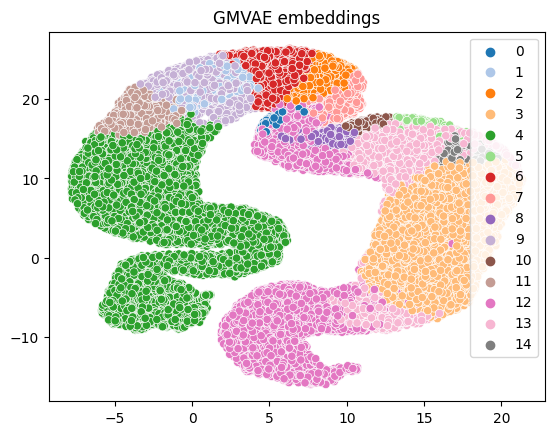

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

#tt = GaussianMixture(n_components=5, covariance_type="diag", reg_covar=1e-04).fit(emb.numpy())
#means = tt.means_
means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab20")
means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
#sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("GMVAE embeddings")

# plt.legend("")
plt.show()

In [ ]:
cons.get_gmm_params['weights'].numpy().sum()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))
